# Prediction time!

## Importing libraries

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sktime.forecasting.base import BaseForecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon

## Reading and preparing data

In [121]:
df = pd.read_csv(r'C:\Users\1\DataAnalyticsProjects\ТИЦ\Prediction\prediction.csv')

In [122]:
df.tail(3)

,Date,Weekday,Amount
119,2024-06-28,Friday,41
120,2024-06-29,Saturday,89
121,2024-06-30,Sunday,82


In [123]:
df = df.set_index('Date')
df = df.drop(columns=['Weekday'])
# df = df.loc[df.index > '2024-05-14']

In [124]:
df.index

Index(['2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-05',
       '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-10',
       ...
       '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
       '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29', '2024-06-30'],
      dtype='object', name='Date', length=122)

Set datetype and frequency

In [125]:
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')

In [126]:
df.index

DatetimeIndex(['2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04',
               '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08',
               '2024-03-09', '2024-03-10',
               ...
               '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24',
               '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28',
               '2024-06-29', '2024-06-30'],
              dtype='datetime64[ns]', name='Date', length=122, freq='D')

Simple line chart

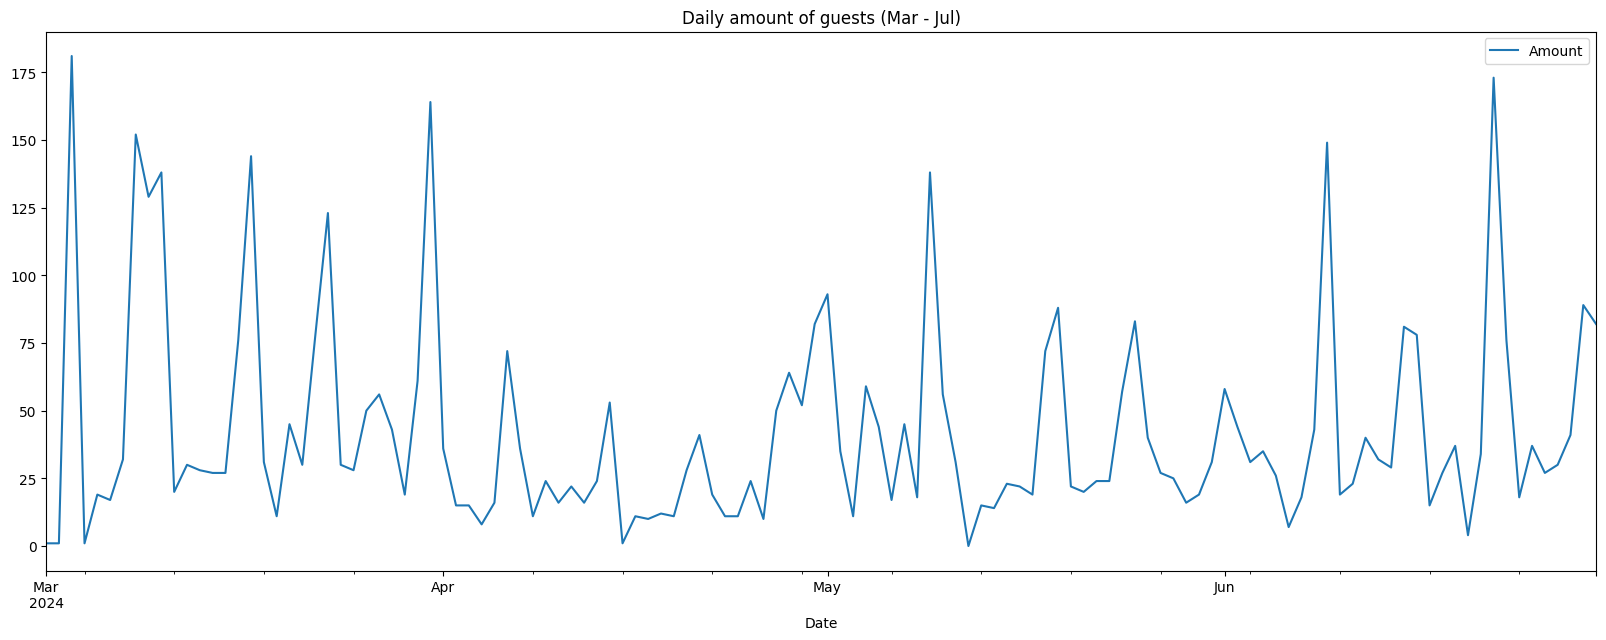

In [127]:
df.plot(figsize=(20, 7), style='-')
plt.title("Daily amount of guests (Mar - Jul)")
plt.show()

Creating function to add parameters like Month, Day of week and Day of month

In [128]:
def add_parameters(data: pd.DataFrame =df, weekday: bool =True, day: bool =True, month: bool =True) -> pd.DataFrame:
    df = data.copy()

    if weekday is True:
        df['weekday'] = df.index.weekday
    if day is True:
        df['day'] = df.index.day
    if month is True:
        df['month'] = df.index.month
     
    return df
    

## Train-Test Split

In [129]:
# train, test = train_test_split(df, train_size=0.84, shuffle=False)
train, test = df.loc[df.index < '2024-06-02'], df.loc[df.index >= '2024-06-02']

In [130]:
train.shape, test.shape

((93, 1), (29, 1))

Add parameters to Train and Test dataframes

In [131]:
train, test = add_parameters(train), add_parameters(test)
train.sample(3)

,Amount,weekday,day,month
Date,,,,
2024-05-31,31,4,31,5
2024-04-22,19,0,22,4
2024-06-01,58,5,1,6


## Choosing model and features

I want to decide if I need to include Month to features. I'm going to run some quick tests to help me make a decision

In [132]:
def validation_metrics(y_true, y_pred, model):
    return f"RMSE = {round(root_mean_squared_error(y_true, y_pred), 3)}, "\
            f"MAE = {round(mean_absolute_error(y_true=y_true, y_pred=y_pred), 3)}, "\
                f"R_2 = {round(r2_score(y_true=y_true, y_pred=y_pred), 3)}, "\
                    f"WAPE = {round((y_true - y_pred).abs().sum() / y_true.sum(), 3)}"
                    # f"Score = {round(model.score(X=X_test, y=y_test), 3)}"

Month included

In [133]:
X_train, y_train = train[['weekday', 'day', 'month']], train[['Amount']]
X_test, y_test = test[['weekday', 'day', 'month']], test[['Amount']]

c:\Users\1\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\1\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
16:22:13 - cmdstanpy - INFO - Chain [1] start processing
16:22:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

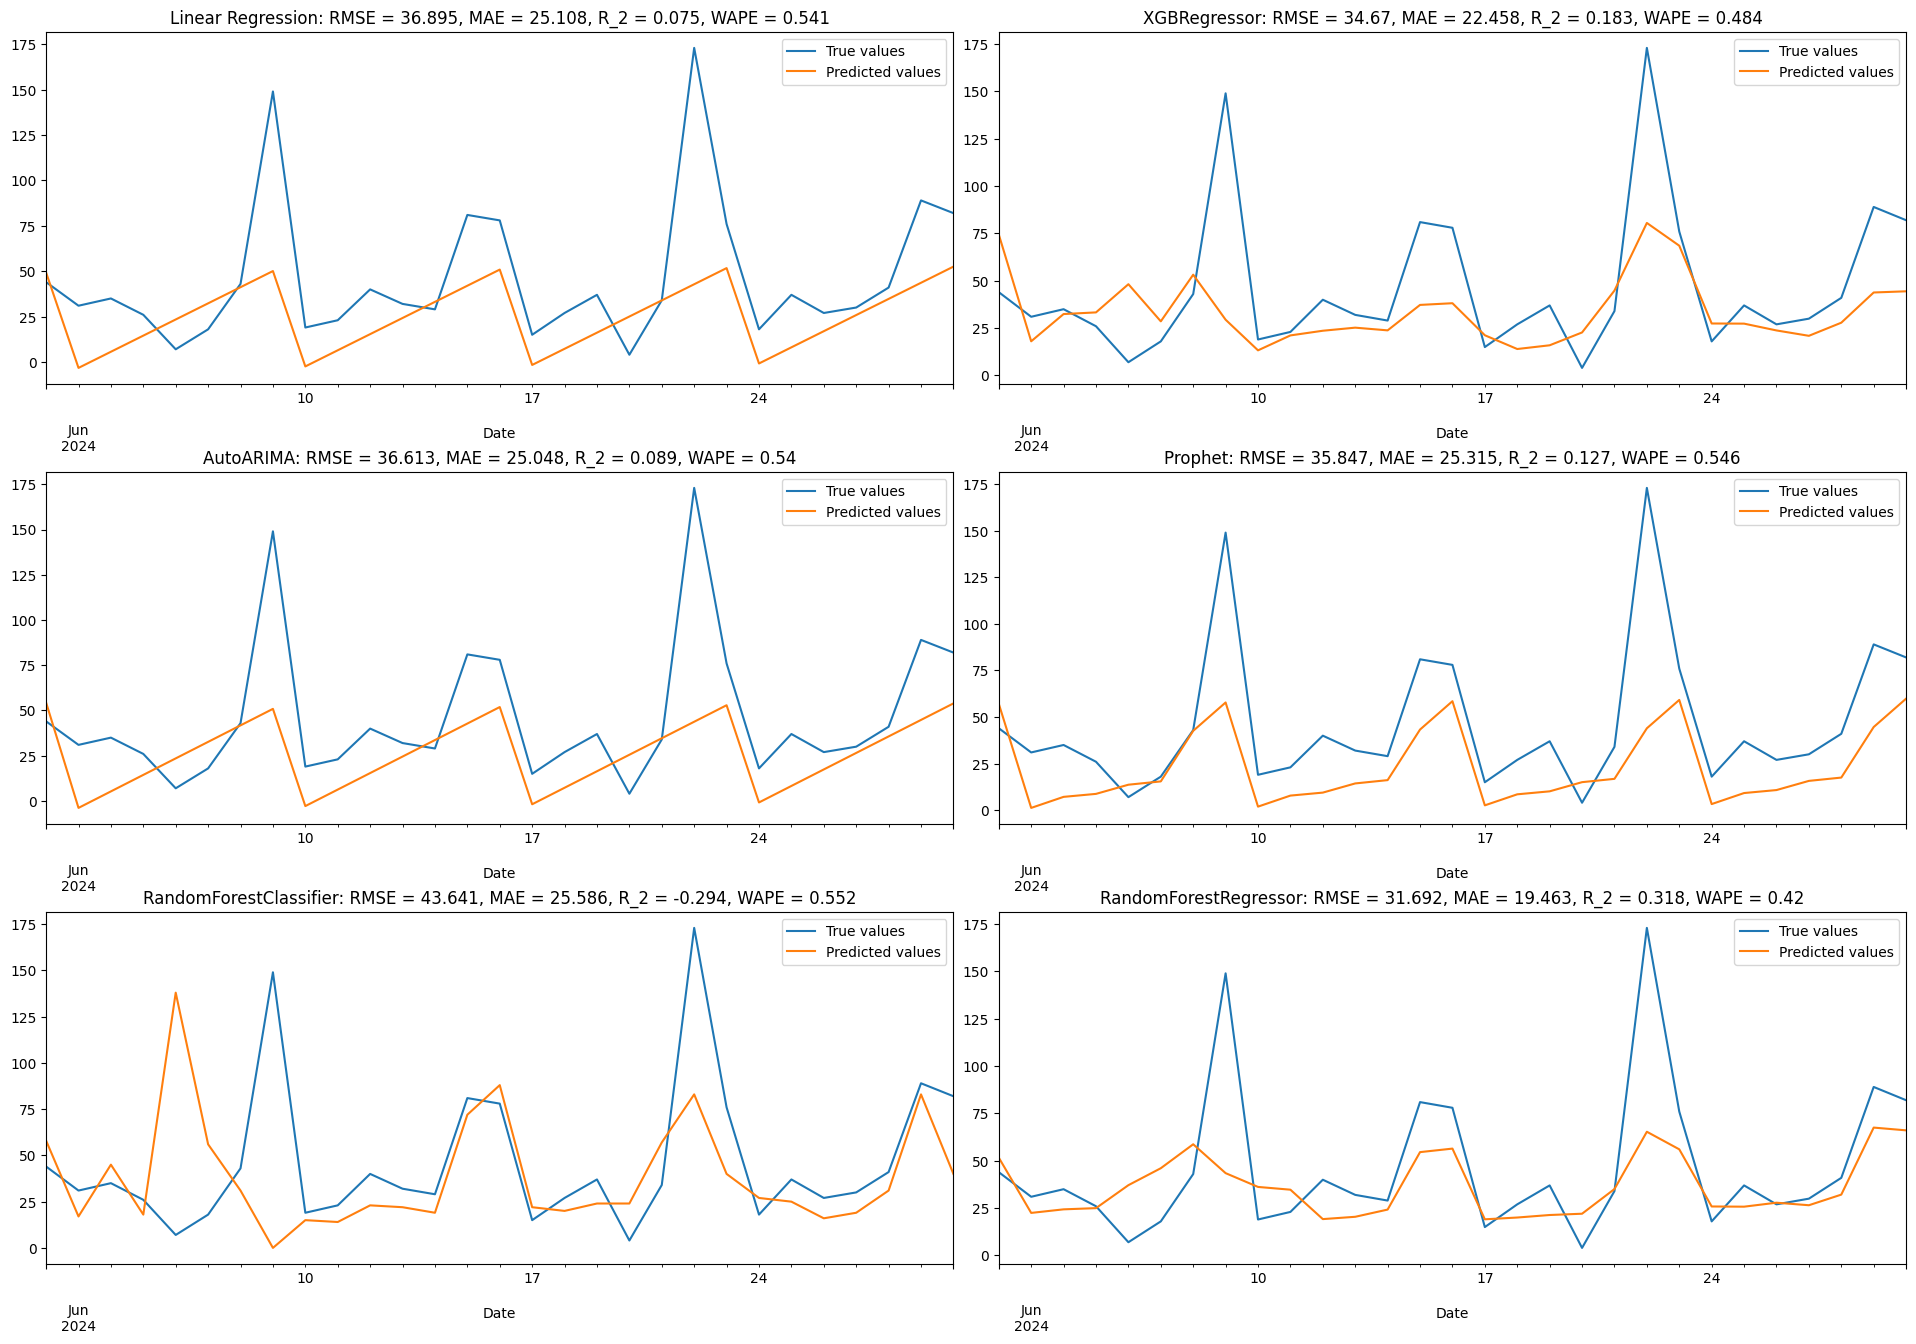

In [134]:
fig, axs = plt.subplots(figsize=(24, 16), ncols=2, nrows=3)
axs = axs.flat

reg = LinearRegression()
test['Pred_w_month'] = reg.fit(X=X_train, y=y_train).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[0], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[0].legend(['True values', 'Predicted values']), axs[0].set_title(f"Linear Regression: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=reg)}")

xgbreg = xgb.XGBRegressor()
test['Pred_w_month'] = xgbreg.fit(X=X_train, y=y_train).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[1], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[1].legend(['True values', 'Predicted values']), axs[1].set_title(f"XGBRegressor: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=xgbreg)}")

arima = AutoARIMA()
test['Pred_w_month'] = arima.fit(X=X_train, y=y_train, fh=X_test.index).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[2], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[2].legend(['True values', 'Predicted values']), axs[2].set_title(f"AutoARIMA: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=arima)}")

prophet = Prophet()
test['Pred_w_month'] = prophet.fit(y=y_train, X=X_train, fh=X_test.index).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[3], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[3].legend(['True values', 'Predicted values']), axs[3].set_title(f"Prophet: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=prophet)}")

rfc = RandomForestClassifier()
test['Pred_w_month'] = rfc.fit(y=y_train, X=X_train).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[4], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[4].legend(['True values', 'Predicted values']), axs[4].set_title(f"RandomForestClassifier: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=rfc)}")

rfr = RandomForestRegressor()
test['Pred_w_month'] = rfr.fit(y=y_train, X=X_train).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[5], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[5].legend(['True values', 'Predicted values']), axs[5].set_title(f"RandomForestRegressor: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=rfr)}")

plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.show()

Month excluded

In [135]:
X_train, y_train = train[['weekday', 'day']], train[['Amount']]
X_test, y_test = test[['weekday', 'day']], test[['Amount']]

c:\Users\1\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\1\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\1\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\1\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\1\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966:

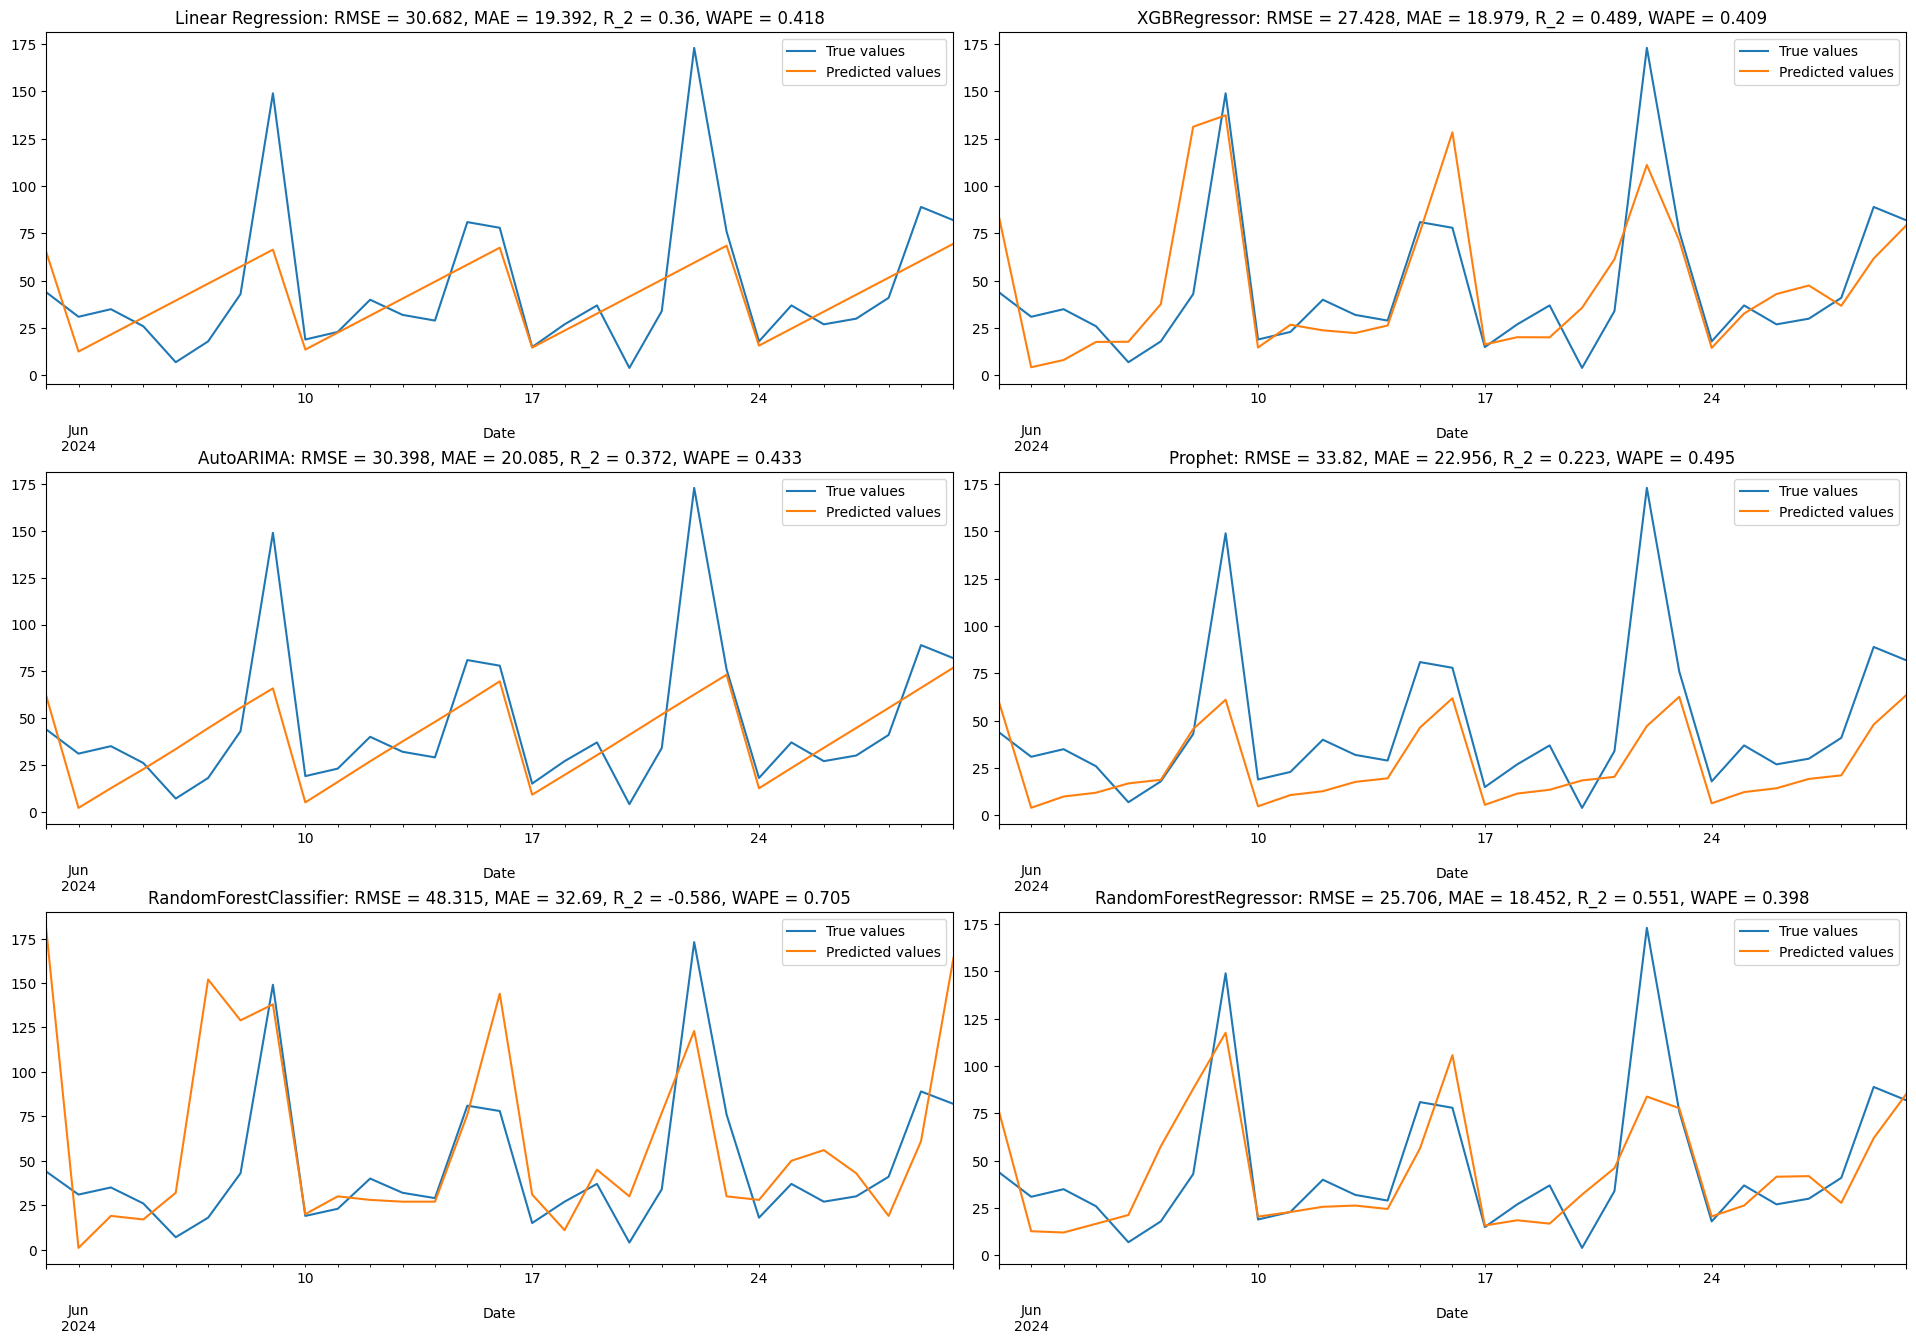

In [136]:
fig, axs = plt.subplots(figsize=(24, 16), ncols=2, nrows=3)
axs = axs.flat

reg = LinearRegression()
test['Pred_w_month'] = reg.fit(X=X_train, y=y_train).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[0], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[0].legend(['True values', 'Predicted values']), axs[0].set_title(f"Linear Regression: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=reg)}")

xgbreg = xgb.XGBRegressor()
test['Pred_w_month'] = xgbreg.fit(X=X_train, y=y_train).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[1], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[1].legend(['True values', 'Predicted values']), axs[1].set_title(f"XGBRegressor: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=xgbreg)}")

arima = AutoARIMA()
test['Pred_w_month'] = arima.fit(X=X_train, y=y_train, fh=X_test.index).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[2], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[2].legend(['True values', 'Predicted values']), axs[2].set_title(f"AutoARIMA: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=arima)}")

prophet = Prophet()
test['Pred_w_month'] = prophet.fit(y=y_train, X=X_train, fh=X_test.index).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[3], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[3].legend(['True values', 'Predicted values']), axs[3].set_title(f"Prophet: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=prophet)}")

rfc = RandomForestClassifier()
test['Pred_w_month'] = rfc.fit(y=y_train, X=X_train).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[4], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[4].legend(['True values', 'Predicted values']), axs[4].set_title(f"RandomForestClassifier: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=rfc)}")

rfr = RandomForestRegressor()
test['Pred_w_month'] = rfr.fit(y=y_train, X=X_train).predict(X=X_test)
test[['Amount', 'Pred_w_month']].plot(ax=axs[5], color=['C0', 'C1']).set_xlabel('Date', labelpad=-20)
axs[5].legend(['True values', 'Predicted values']), axs[5].set_title(f"RandomForestRegressor: {validation_metrics(y_true=test['Amount'], y_pred=test['Pred_w_month'], model=rfr)}")

plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.show()

Let's work with RFR and month excluded

In [137]:
hm = {}
for r_s in range(10**3):
    rfr = RandomForestRegressor(n_estimators=15, random_state=r_s)

    rfr.fit(X=X_train, y=y_train)
    test['RFR_prediction'] = rfr.predict(X=X_test)
    mae, r_2 = mean_absolute_error(y_true=test['Amount'], y_pred=test['RFR_prediction']), r2_score(y_true=test['Amount'], y_pred=test['RFR_prediction'])

    if r_2 >= 0.6:
        hm[r_s] = r_2

hm

c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using r

{90: 0.6021781897764309,
 113: 0.6266830661947853,
 141: 0.672945391869022,
 285: 0.6003823516952043,
 399: 0.6190376621912613,
 437: 0.6240595330155386,
 529: 0.6269265855450079,
 566: 0.6090938686300147,
 583: 0.6234164295412656,
 656: 0.6217124187652534,
 664: 0.6069456094284363,
 697: 0.6142724289036657,
 783: 0.6403394106365732,
 799: 0.6165942437943511,
 829: 0.607344672989532,
 850: 0.6123303126321602,
 857: 0.6090271324592182,
 957: 0.6352252960567177}

Get best R_2 values

c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


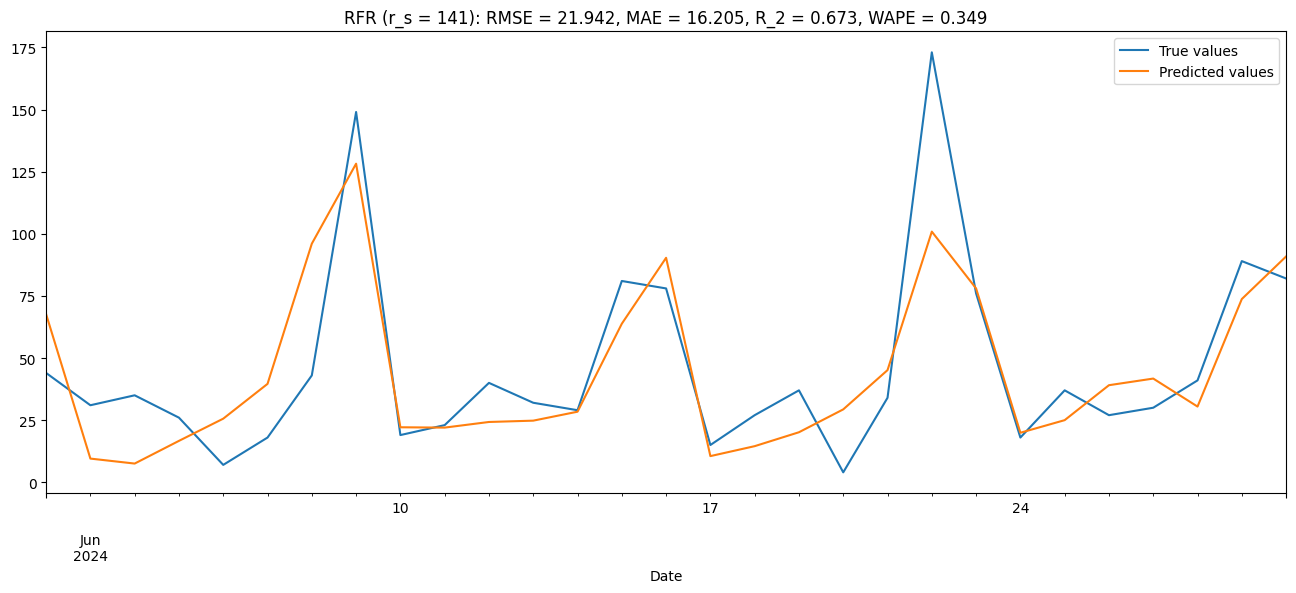

c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


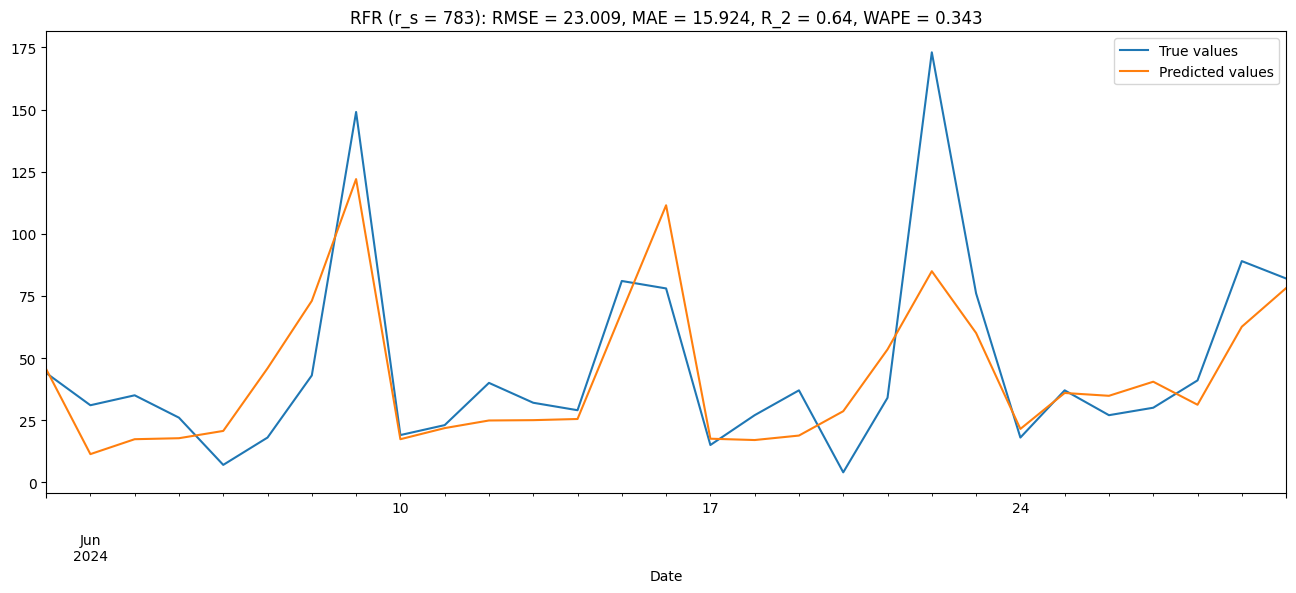

c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


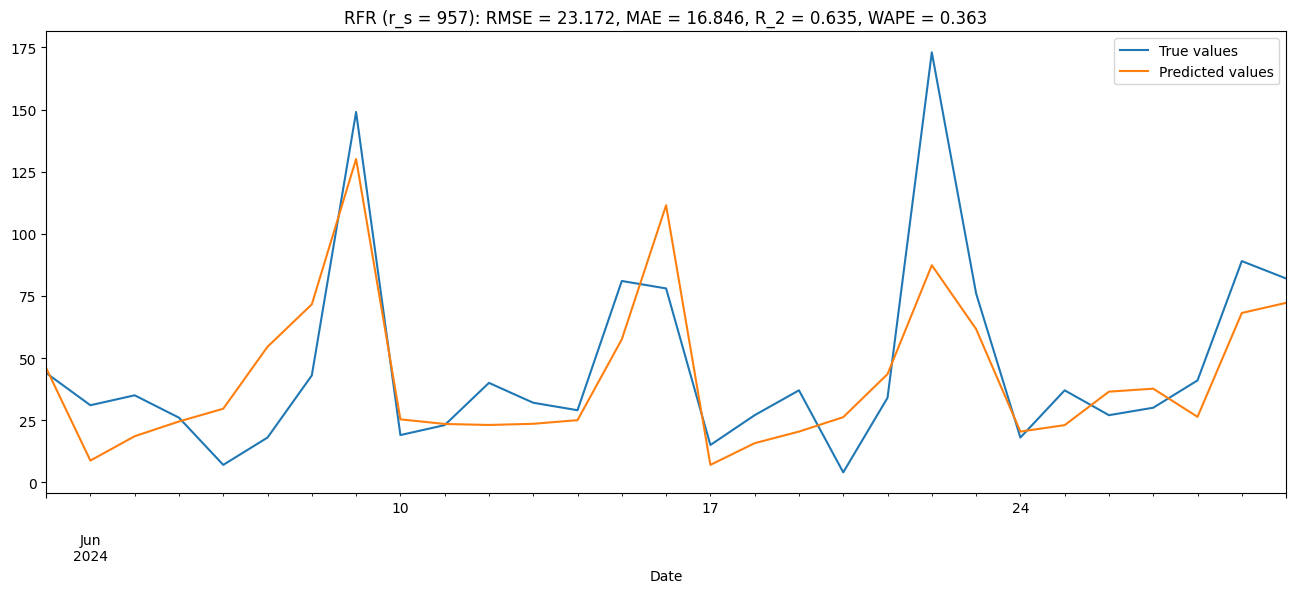

In [138]:
for r_s in hm:
    if hm[r_s] < 0.63:
        continue

    rfr = RandomForestRegressor(n_estimators=15, random_state=r_s)
    rfr.fit(X=X_train, y=y_train)

    test['RFR_prediction'] = rfr.predict(X=X_test)
    mae, r_2 = mean_absolute_error(y_true=test['Amount'], y_pred=test['RFR_prediction']), r2_score(y_true=test['Amount'], y_pred=test['RFR_prediction'])

    test[['Amount', 'RFR_prediction']].plot(figsize=(16, 6))
    plt.legend(['True values', 'Predicted values'])
    plt.title(f"RFR (r_s = {r_s}): {validation_metrics(y_true=test['Amount'], y_pred=test['RFR_prediction'], model=rfc)}")
    plt.show()

In [139]:
add_pred = pd.DataFrame(pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), end=df.index[-1] + pd.DateOffset(days=31)), columns=['Date'])
add_pred = add_pred.set_index(['Date'])
add_pred.tail(3)


""
Date
2024-07-29
2024-07-30
2024-07-31


In [140]:
df_pred = pd.concat(objs=[df, add_pred])
df_pred = add_parameters(df_pred, month=False)
# df_pred = df_pred.query('index < "2024-04-01" | index > "2024-05-01"')
df_pred.sample(5)

,Amount,weekday,day
Date,,,
2024-03-14,27.0,3,14
2024-06-14,29.0,4,14
2024-04-01,36.0,0,1
2024-07-02,NaN,1,2
2024-04-14,53.0,6,14


In [141]:

train, pred = df_pred.loc[df_pred.index < "2024-07-01"], df_pred.loc[df_pred.index >= "2024-07-01"]
train = train.loc[train.index > "2024-05-15"]
train.shape, pred.shape

((46, 3), (31, 3))

In [142]:

X_train, y_train = train[['weekday', 'day']], train[['Amount']]
X_train.sample(2)


,weekday,day
Date,,
2024-06-18,1,18
2024-06-08,5,8


In [ ]:
X_pred = pred[['weekday', 'day']]
X_pred.sample(2)

c:\Users\1\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\1\AppData\Local\Temp\ipykernel_9872\690801916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['Prediction'] = rfr.predict(X=X_pred)


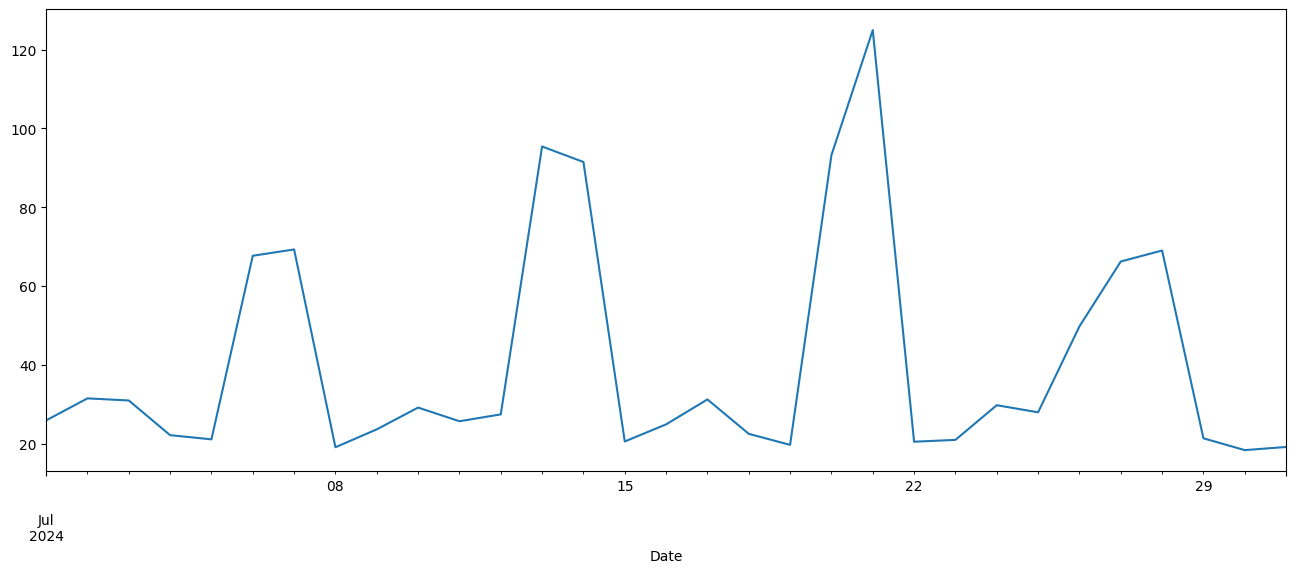

In [143]:
rfr = RandomForestRegressor(n_estimators=15, random_state=141)
rfr.fit(X=X_train, y=y_train)

pred['Prediction'] = rfr.predict(X=X_pred)
pred['Prediction'].plot(figsize=(16, 6))
plt.show()

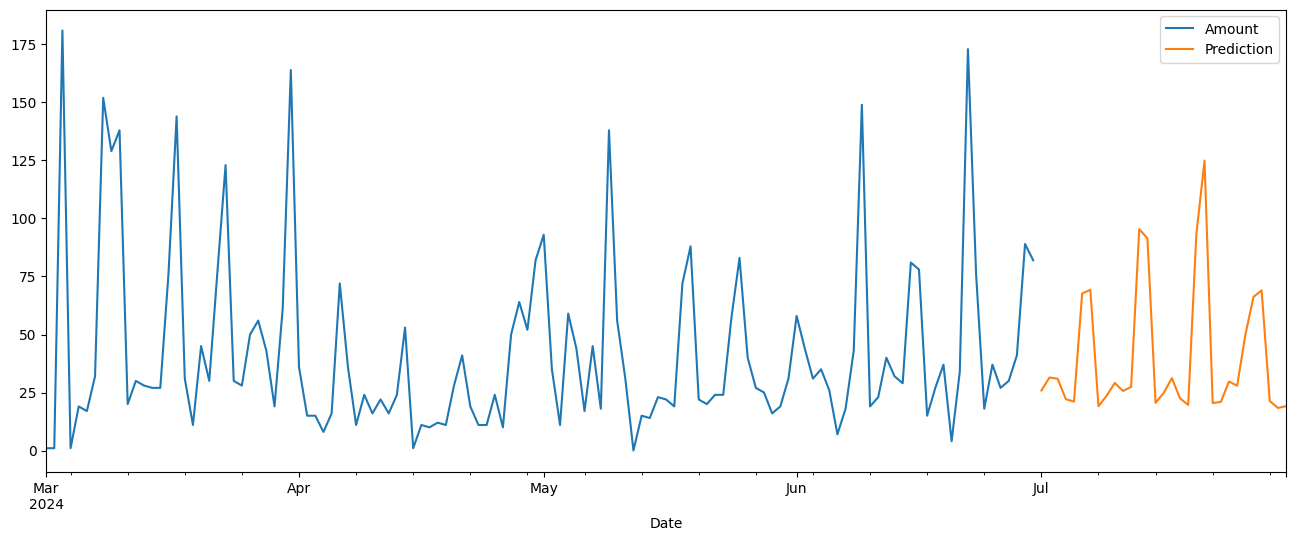

In [144]:
df_pred['Prediction'] = pred['Prediction']
df_pred[['Amount', 'Prediction']].plot(figsize=(16, 6))
plt.show()